In [9]:
#This is done to extract the contents of ZIP file located in google drive to specified directory using 'zipfile' module:
import zipfile
import os

#specify the path to yout ZIP file in google drive
zip_file_path="/content/drive/MyDrive/datashit.zip"

#specify the directory where we want to extract
extracted_folder='/content/extracted/'

try:
  os.makedirs(extracted_folder, exist_ok=True)

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:

    zip_ref.extractall(extracted_folder)

  print(f"contents of '{zip_file_path}' extracted to '{extracted_folder}'.")
except zipfile.BadZipFile:
  print(f"error: '{zip_file_path}' is not a valid ZIP file")
except Exception as e:
  print(f"An error occurred: {e}")

contents of '/content/drive/MyDrive/datashit.zip' extracted to '/content/extracted/'.


cuda
Missing files:
ss02 (1014).jpg
Updated DataFrame:
           Image Name     MOS  Unnamed: 2  Unnamed: 3
0     ss03 (3753).jpg  0.8471         NaN         NaN
1     ss01 (1726).jpg  0.2874         NaN         NaN
2     ss03 (5905).jpg  0.7314         NaN         NaN
3      ss03 (961).jpg  0.6596         NaN         NaN
4     ss03 (5215).jpg  0.7628         NaN         NaN
...               ...     ...         ...         ...
9994  ss02 (1461).jpg  0.5006         NaN         NaN
9995  ss03 (3367).jpg  0.7610         NaN         NaN
9996  ss03 (5623).jpg  0.8478         NaN         NaN
9997  ss03 (2029).jpg  0.7702         NaN         NaN
9998  ss01 (1504).jpg  0.5420         NaN         NaN

[9999 rows x 4 columns]
Mean: [117.87728881835938, 111.98226165771484, 104.15895080566406]
Standard Deviation: [49.17100524902344, 46.56146240234375, 47.649356842041016]


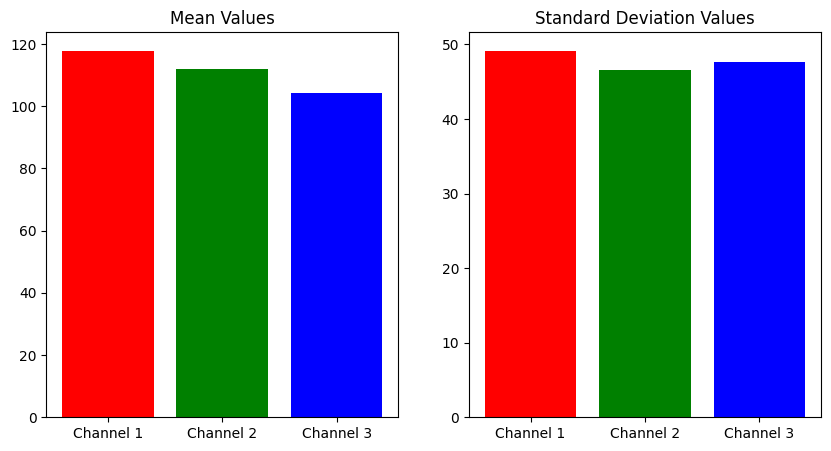

No. of training Images:  9999
No. of testing Images:  2000
No. of training Images:  8999
No. of Validation Images:  1000


In [10]:

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import torchvision
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader , random_split


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

import os
import pandas as pd

def check_and_remove_missing_files(folder_path, dataframe):
    file_paths = dataframe['Image Name'].tolist()

    missing_files = []

    for file_path in file_paths:
        full_path = os.path.join(folder_path, file_path)
        if not os.path.exists(full_path):
            missing_files.append(file_path)

    dataframe = dataframe[~dataframe['Image Name'].isin(missing_files)].reset_index(drop=True)

    return missing_files, dataframe
#Loading the Image folder
image_folder_path = '/content/extracted/BIQ2021-main/Images'

#Loading the CSV file for the dataframe
df = pd.read_csv('/content/extracted/BIQ2021-main/Train (Images and MOS).csv')

missing_files, updated_df = check_and_remove_missing_files(image_folder_path, df)

if missing_files:
    print("Missing files:")
    for file in missing_files:
        print(file)
else:
    print("No missing files.")

print("Updated DataFrame:")
print(updated_df)

class CustomDataset(Dataset):
    def __init__(self , dataframe ,root_dir ,transform=None):
        self.dataframe = dataframe
        self.Images_root = root_dir + '/Images'
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.Images_root, img_name)

        #Reading Image using Torchvision
        image = torchvision.io.read_image(img_path)
        image_resized = v2.functional.resize(image,size = [32,32],antialias=True)
        #Changing integer to float datatype for Image
        image = image_resized.float()
        mos_score = self.dataframe.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image,mos_score

        #Using Updated Dataframe after deleting missing filenames from the Dataframe
df = updated_df
ds = CustomDataset(df,'/content/extracted/BIQ2021-main',transform=None)

def calculate_mean_std(dataset):
    #dataloader to go through each image of batch size 1
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    # Initialize lists to store channel-wise mean and standard deviation
    channel_means = []
    channel_stds = []
    # Loop through each batch in the DataLoader
    for batch in dataloader:
        img = batch[0]
#         print(img.size())
 # Calculate mean and standard deviation for each channel
        mean = torch.mean(img, dim=(2, 3))
        std = torch.std(img, dim=(2,3))
        mean = mean

        #Append it to the lists
        channel_means.append(mean)
        channel_stds.append(std)

    # Calculate the mean and standard deviation across all images
#     print(channel_means)
    overall_mean = torch.mean(torch.stack(channel_means), dim=0)
    overall_std = torch.mean(torch.stack(channel_stds), dim=0)

    return overall_mean.squeeze().numpy().tolist(), overall_std.squeeze().numpy().tolist()

mean , std_dev = calculate_mean_std(ds)

print(f'Mean: {mean}')
print(f'Standard Deviation: {std_dev}')

# Function to plot mean and standard deviation
def plot_mean_std(mean, std_dev):
    labels = ['Channel 1', 'Channel 2', 'Channel 3']  # Assuming RGB channels

    # Plotting mean values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.bar(labels, mean, color=['red', 'green', 'blue'])
    plt.title('Mean Values')

    # Plotting standard deviation values
    plt.subplot(1, 2, 2)
    plt.bar(labels, std_dev, color=['red', 'green', 'blue'])
    plt.title('Standard Deviation Values')

    plt.show()

# Plotting mean and standard deviation
plot_mean_std(mean, std_dev)

train_transform = v2.Compose([v2.RandomHorizontalFlip(0.6),v2.Normalize(mean = mean , std = std_dev)])
test_transform = v2.Compose([v2.Normalize(mean = mean , std = std_dev)])

# Train dataset from the updated dataframe and applied transforms

train_dataset = CustomDataset(df,'/content/extracted/BIQ2021-main',transform=train_transform)

#Test Dataframe from the datadir and with respective transformations
test_df = pd.read_csv('/content/extracted/BIQ2021-main/Test (Images and MOS).csv')
test_dataset = CustomDataset(test_df , '/content/extracted/BIQ2021-main', transform = test_transform )

print("No. of training Images: ",len(train_dataset))
print("No. of testing Images: ",len(test_dataset))

#Dataset is split into 90% train and 10% validation from the training dataset.
#We have used Pytorch random_split class to split into training and validation datasets

train_size = int(0.9 * len(train_dataset))
valid_size = len(train_dataset) - train_size

train_ds, valid_ds = random_split(train_dataset, [train_size, valid_size])

print("No. of training Images: ",len(train_ds))
print("No. of Validation Images: ",len(valid_ds))
